# Forecasting the Number Of Vehicles Entering the Parking Per Day

Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.forecasting.arima import AutoARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.arima.model import ARIMA
import warnings


## Loading Data 

In [2]:
parking_data = pd.read_csv('parkingLot (1).csv')

In [3]:
parking_data.head(10)

,vehicle_no,timestamp,camera_id
0,MHUN7063,2024-09-12 05:00:00,1
1,MHYN4677,2024-09-12 05:00:00,1
2,MHEL6595,2024-09-12 05:00:00,1
3,MHNQ2590,2024-09-12 05:00:00,1
4,MHHA0518,2024-09-12 05:00:00,1
5,MHGS9163,2024-09-12 05:00:00,1
6,MHJU1350,2024-09-12 05:00:00,1
7,MHYN8096,2024-09-12 05:00:00,1
8,MHZI0593,2024-09-12 05:00:00,1
9,MHBR3603,2024-09-12 05:00:00,1


In [4]:
len(parking_data)

106694

## Parsing the Data According to the need of the Assignment 

We are supposed to model the number of cars entering the parking lot per day. For this, we will have to group the given data to include the count of cars arriving each day

We will select only those cars which entered the parking lot. For doing this, we will take out all the rows with `camera_id` equal to  `1 `.

In [5]:
car_entering_data = parking_data[(parking_data['camera_id']==1)]

In [6]:
warnings.filterwarnings('ignore')
car_entering_data['Count'] = 1

In [7]:
car_entering_data.head()

,vehicle_no,timestamp,camera_id,Count
0,MHUN7063,2024-09-12 05:00:00,1,1
1,MHYN4677,2024-09-12 05:00:00,1,1
2,MHEL6595,2024-09-12 05:00:00,1,1
3,MHNQ2590,2024-09-12 05:00:00,1,1
4,MHHA0518,2024-09-12 05:00:00,1,1


In [8]:
len(car_entering_data)/len(parking_data)

0.5

In [9]:
car_entering_data['timestamp'].dtype

dtype('O')

We will first convert this to pd.timeseries datatime

In [10]:
warnings.filterwarnings('ignore')
car_entering_data['timestamp'] = pd.to_datetime(car_entering_data['timestamp'])

In [11]:
car_entering_data['timestamp'].dtype

dtype('<M8[ns]')

In [12]:
cars_per_day = car_entering_data.groupby(pd.Grouper(key='timestamp', freq='D'))['Count'].sum()

In [13]:
cars_per_day

timestamp
2024-09-12     886
2024-09-13     809
2024-09-14     925
2024-09-15    1073
2024-09-16     843
              ... 
2024-11-09     906
2024-11-10     944
2024-11-11     828
2024-11-12     806
2024-11-13     781
Freq: D, Name: Count, Length: 63, dtype: int64

## Visualizing the Time Series

<Axes: xlabel='timestamp'>

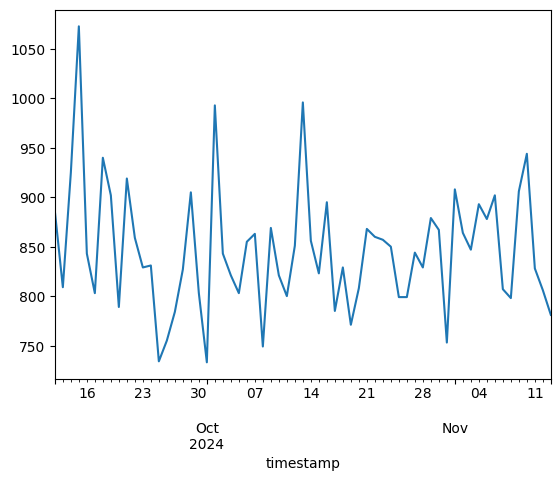

In [14]:
cars_per_day.plot()

## Inference From Data

### Applying the Augmented Dickey-Fuller test to check if the data is stationary or not
The AGFuller Test has the null hypothesis that the series is Non-Stationary. Therefore if the p-value is small, then the series is not non-stationary.

In [15]:
# adapted from https://colab.research.google.com/drive/1Z4zNI_bVXoFQBsCHUtxBDCBno6yhXceB?usp=sharing#scrollTo=BPnj35XhmNlt
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y, autolag='AIC')[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

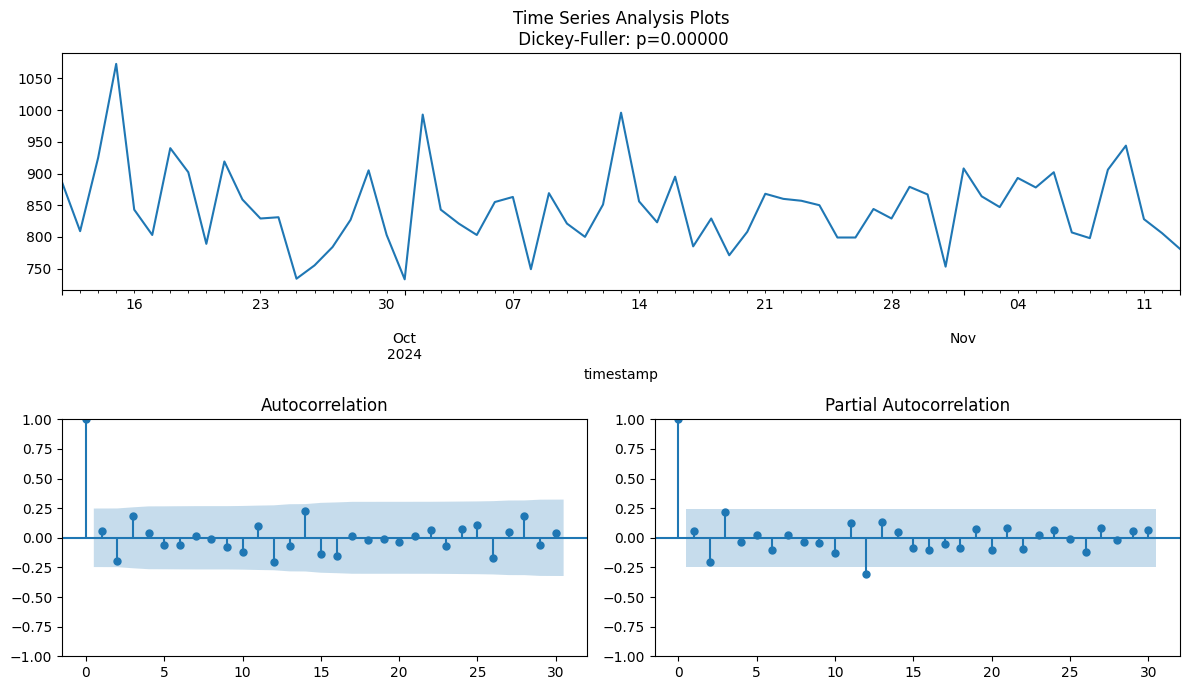

In [16]:
tsplot(cars_per_day, lags=30)

Since $p-value < 0.05$, the time-series is $stationary$.

Checking for Seasonality in the Data

In [17]:
def check_seasonality(time_series, period=None, model='additive', plot=True):

    decomposition = seasonal_decompose(time_series, model=model, period=period)
    
    if plot:
        # plt.figure(figsize=(40, 8))
        decomposition.plot()
        plt.show()
    
    return {
        'Trend': decomposition.trend,
        'Seasonal': decomposition.seasonal,
        'Residual': decomposition.resid
    }

> 
> For the statistical method used by [statsmodels.tsa.seasonal.seasonal_decompose](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html#statsmodels-tsa-seasonal-seasonal-decompose), checkout [this](https://otexts.com/fpp2/decomposition.html).

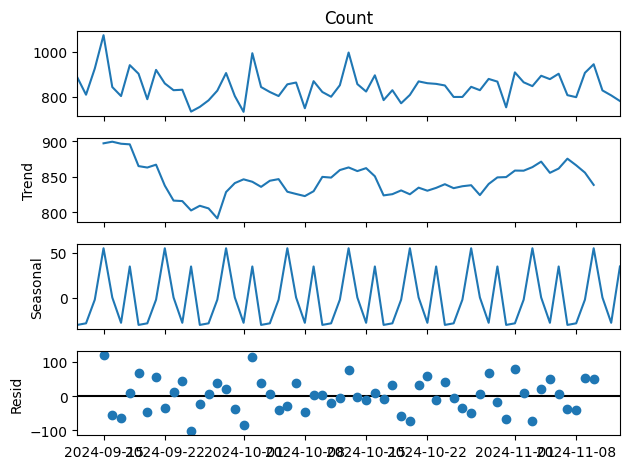

In [18]:
_ = check_seasonality(cars_per_day, period=7) # Weekly seasonality

Let us look at Moving Average of the Time Series so that we can check the seasonality without any noise in the data.

So by looking at the trend and seasonal components, we can see that there is a weekly seasonality in the data. Using a Seasonal ARIMA Model here might be benificial.

# Fitting ARIMA Model

In [19]:
test_len = int(len(cars_per_day) * 0.12)
_train, _test = cars_per_day.iloc[:-test_len], cars_per_day.iloc[-test_len:]
_train

timestamp
2024-09-12     886
2024-09-13     809
2024-09-14     925
2024-09-15    1073
2024-09-16     843
2024-09-17     803
2024-09-18     940
2024-09-19     902
2024-09-20     789
2024-09-21     919
2024-09-22     859
2024-09-23     829
2024-09-24     831
2024-09-25     734
2024-09-26     755
2024-09-27     784
2024-09-28     827
2024-09-29     905
2024-09-30     803
2024-10-01     733
2024-10-02     993
2024-10-03     843
2024-10-04     821
2024-10-05     803
2024-10-06     855
2024-10-07     863
2024-10-08     749
2024-10-09     869
2024-10-10     821
2024-10-11     800
2024-10-12     851
2024-10-13     996
2024-10-14     856
2024-10-15     823
2024-10-16     895
2024-10-17     785
2024-10-18     829
2024-10-19     771
2024-10-20     808
2024-10-21     868
2024-10-22     860
2024-10-23     857
2024-10-24     850
2024-10-25     799
2024-10-26     799
2024-10-27     844
2024-10-28     829
2024-10-29     879
2024-10-30     867
2024-10-31     753
2024-11-01     908
2024-11-02     864
20

In [20]:
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Calculate Mean Absolute Scaled Error (MASE)
    
    Parameters:
    y_true (array-like): Actual values
    y_pred (array-like): Predicted values
    
    Returns:
    float: MASE value
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    n = len(y_true)
    mae = np.mean(np.abs(y_true - y_pred))
    naive_mae = np.mean(np.abs(y_true[1:] - y_true[:-1]))
	
	# THe naive predictor used here is the previous value.

    return mae / naive_mae


In [21]:
def mean_absolute_percentage_error(y_true, y_pred):
	"""
	Calculate Mean Absolute Percentage Error (MAPE)
	
	Parameters:
	y_true (array-like): Actual values
	y_pred (array-like): Predicted values
	
	Returns:
	float: MAPE value
	"""
	y_true = np.array(y_true)
	y_pred = np.array(y_pred)
	
	return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [22]:
def plot_forecast(series_train, series_test, forecast_object):
    
    # mae = mean_absolute_error(series_test, forecast)
    mase = mean_absolute_scaled_error(series_test, forecast_object.predicted_mean)
    mape = mean_absolute_percentage_error(series_test, forecast_object.predicted_mean)

    plt.figure(figsize=(12, 6))
    series_train.plot(label='Train', color='blue')
    series_test.plot(label='Test', color='green')
    # forecast.plot(label='Forecast', color='red')
    forecast_object.index = series_test.index

    plt.plot(forecast_object.predicted_mean, label='Forecast', color='red')
    plt.fill_between(forecast_object.conf_int().index, forecast_object.conf_int().iloc[:, 0], forecast_object.conf_int().iloc[:, 1], color='pink')
    plt.legend()
    plt.title(f'MASE: {mase:.2f}, MAPE: {mape:.2f}')
    # plt.show()
    
    return mase, mape

In [23]:
def fit_model(parms, train_data, test_data):
	p, d, q = parms
	forecaster = ARIMA(train_data, order=(p, d, q))
	fitted_model = forecaster.fit()

	# Generate forecast and get confidence intervals
	forecast_obj = fitted_model.get_forecast(steps=len(test_data))

	
	mase, mape = plot_forecast(train_data, test_data, forecast_obj)
	

	print(f"MAPE: {mape} MASE: {mase} for {parms}" )
	return mase, mape


Using the Auto Arima Model to Generate Forecast

In [24]:
warnings.filterwarnings('ignore')
forecaster = AutoARIMA( start_p=0, max_p=3,suppress_warnings=True, seasonal=False)
forecaster.fit(_train)
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   56
Model:                        SARIMAX   Log Likelihood                -312.041
Date:                Sun, 27 Oct 2024   AIC                            628.083
Time:                        21:42:53   BIC                            632.133
Sample:                    09-12-2024   HQIC                           629.653
                         - 11-06-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    847.8036      9.560     88.679      0.000     829.066     866.542
sigma2      4049.9436    625.645      6.473      0.000    2823.701    5276.186
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                14.79
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.29   Skew:                             0.89
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
forecast = forecaster.predict(fh=range(len(_test)))
forecast_range = forecaster.predict_interval(fh=range(len(_test)))
mase = mean_absolute_scaled_error(_test, forecast)
mape = mean_absolute_percentage_error(_test, forecast)
print(mase,mape)

1.0064978821717376 6.291839640662163


### Manually trying to test various hyper-parameters on the Seasonal Armia Model. 
The data is almost stationary (from the ADFuller test), therefore we keep the ARIMA difference to 0. The data has weekly seasonality, therefore s=7. The auto-regressive lag is kept to be 1 due to the spike in the Autocorrlation at lag 1. 
<br>
For the seasonal autoregreesive term ($P$), we have hypothesized the current value of the lag to be influenced by the values till 3 weeks ago. Therefore we have chosen it to be 2. On the other hand, the the seasonal moving average term ($Q$) was decided by conducting iterations based on what degree of seasonal smoothening is necessary. The seasonal difference is taken as 1 due to 

In [26]:
p, d, q = 1, 0, 1
P, D, Q, s = 3 , 1, 2, 7

In [27]:
warnings.filterwarnings('ignore')
model = SARIMAX(_train, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()

In [28]:
forecast_periods = 7  # Forecast the next 12 months 
own_forecast = results.get_forecast(steps=forecast_periods) 
forecast_mean = own_forecast.predicted_mean 
forecast_ci = own_forecast.conf_int() 

In [29]:
forecast_mean


2024-11-07    822.760565
2024-11-08    836.017171
2024-11-09    808.068760
2024-11-10    897.597193
2024-11-11    861.809804
2024-11-12    885.545055
2024-11-13    870.351060
Freq: D, Name: predicted_mean, dtype: float64

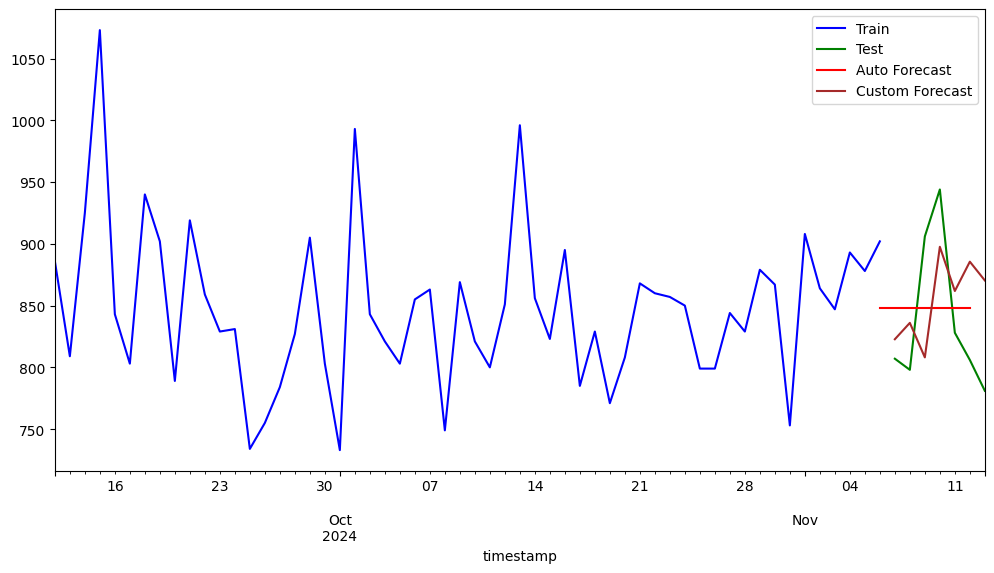

In [30]:
plt.figure(figsize=(12, 6))
_train.plot(label='Train', color='blue')
_test.plot(label='Test', color='green')
forecast.plot(label='Auto Forecast', color='red')
plt.plot(forecast_mean, label='Custom Forecast', color='brown') 
plt.legend()
plt.show()

Reporting Metrics for both the models

In [31]:
auto_mase = mean_absolute_scaled_error(_test, forecast)
auto_mape = mean_absolute_percentage_error(_test, forecast)
custom_mase = mean_absolute_scaled_error(_test, forecast_mean)
custom_mape = mean_absolute_percentage_error(_test, forecast_mean)
print("The MASE and MAPE for Auto ARIMA are: ", auto_mase, auto_mape)
print("The MASE and MAPE for Custom SARIMA are: ", custom_mase, custom_mape)

The MASE and MAPE for Auto ARIMA are:  1.0064978821717376 6.291839640662163
The MASE and MAPE for Custom SARIMA are:  1.0803711641213778 6.83354251589334


As we see, both the models are porforming worser than the NAIVE model

## Generating Forecasts for the next 7 days

We will go ahead with our custom SARIMAX forecaster, since the one given by AutoARIMA seems to overfit. 

In [32]:
p, d, q = 1, 0, 1
P, D, Q, s = 3, 1, 2, 7

In [33]:
warnings.filterwarnings('ignore')
forecast_periods = 7
model = SARIMAX(cars_per_day, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()	
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

In [34]:
forecast_ci

,lower Count,upper Count
2024-11-14,654.368515,866.563938
2024-11-15,741.040680,959.649589
2024-11-16,753.043725,975.129628
2024-11-17,707.198998,931.185392
2024-11-18,749.507534,974.530376
2024-11-19,756.793521,982.368672
2024-11-20,734.769182,960.612566


In [35]:
forecast_mean


2024-11-14    760.466226
2024-11-15    850.345135
2024-11-16    864.086677
2024-11-17    819.192195
2024-11-18    862.018955
2024-11-19    869.581096
2024-11-20    847.690874
Freq: D, Name: predicted_mean, dtype: float64

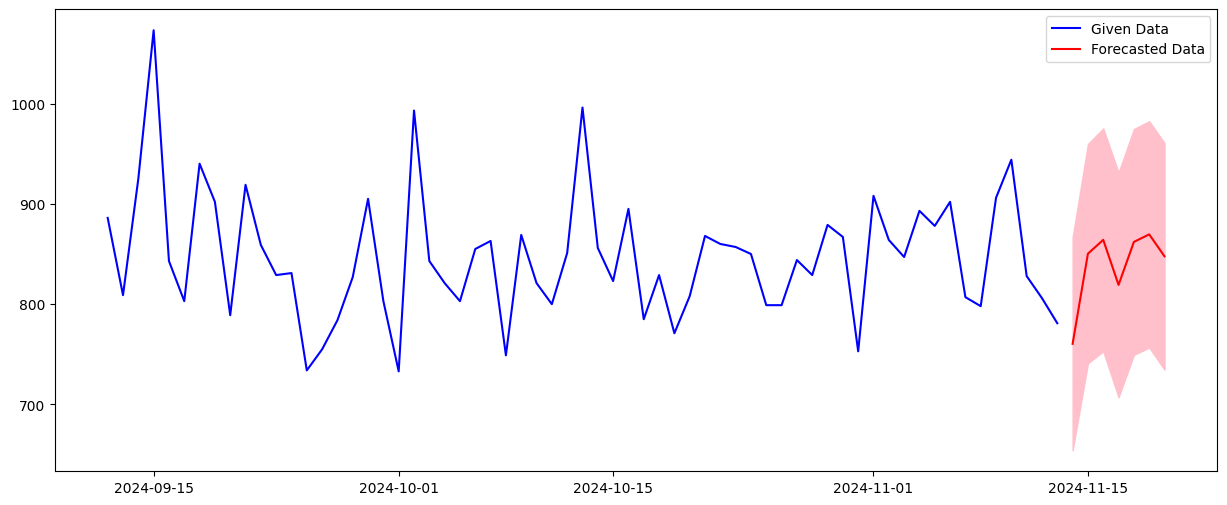

In [36]:
plt.figure(figsize=(15, 6))
plt.plot(cars_per_day, label='Given Data', color='blue')
plt.plot(forecast_mean, label='Forecasted Data', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.legend()
plt.show()